Adapted from MONAI
Copyright (c) MONAI Consortium
Licensed under the Apache License, Version 2.0 (the "License");
You may obtain a copy of the License at
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0

|# Using ControlNet to control image generation

This tutorial illustrates how to use MONAI Generative Models to train a ControlNet [1]. ControlNets are hypernetworks that allow for supplying extra conditioning to ready-trained diffusion models. In this example, we will walk through training a ControlNet that allows us to specify a whole-brain mask that the sampled image must respect.



In summary, the tutorial will cover the following:
1. Loading and preprocessing a dataset (we extract the brain MRI dataset 2D slices from 3D volumes from the BraTS dataset)
2. Training a 2D diffusion model
3. Freeze the diffusion model and train a ControlNet
3. Conditional sampling with the ControlNet

[1] - Zhang et al. [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543)

## Setup environment

In [ ]:
from jupyter_server.transutils import base_dir
!python -c "import monai" || pip install  "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install  matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Setup imports

In [4]:
import os
import time
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.amp import GradScaler, autocast
from torch.nn.functional import affine_grid, grid_sample
from tqdm import tqdm
from monai.inferers import ControlNetDiffusionInferer, DiffusionInferer
from monai.networks.nets import DiffusionModelUNet, ControlNet
from monai.networks.schedulers import DDPMScheduler, DDPMScheduler, RFlowScheduler
# additional imports
from pathlib import Path

print_config()

MONAI version: 1.6.dev2528
Numpy version: 2.1.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7c86eeeae01528647a5703f2fd5df9bc10a8536f
MONAI __file__: C:\Users\<username>\anaconda3\envs\dmcaf\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.15.3
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.3.1
einops version: 0.8.1
transformers version: 4.53.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERS

### Set deterministic training for reproducibility

In [5]:
from models import SEED
set_determinism(SEED)

We create the training and validation datasets:

In [6]:
import importlib
import data
importlib.reload(data)
from data import get_datasets_and_loaders

dataset_used = "fundus"

data_dir = Path.cwd() / "Datasets"
train_ds, val_ds, train_loader, val_loader = get_datasets_and_loaders(batch_size=8, num_workers=4, verbose=True, dataset=dataset_used ,data_dir=data_dir)

Total with masks in CSV: 3103
Valid image-mask pairs: 3103


### Visualise the images and masks
We load some images and masks to make sure things make sense:

Image batch shape: torch.Size([8, 1, 128, 128])
Mask batch shape:  torch.Size([8, 1, 128, 128])


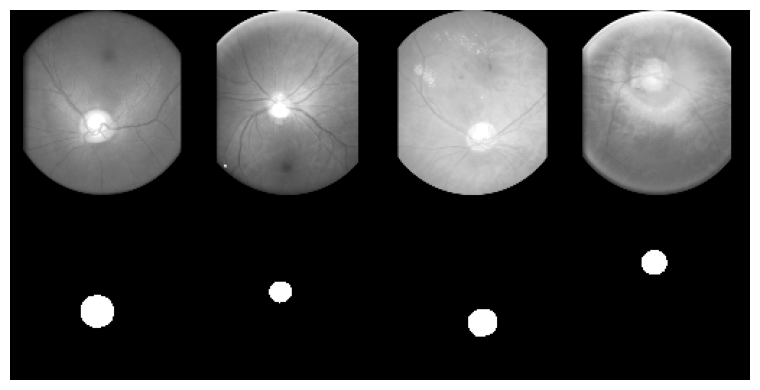

In [7]:
# check_data = first(train_loader)
# print(f"Batch shape: {check_data['image'].shape}")
# image_visualisation = torch.cat(
#     (
#         torch.cat(
#             [
#                 check_data["image"][0, 0],
#                 check_data["image"][1, 0],
#                 check_data["image"][2, 0],
#                 check_data["image"][3, 0],
#             ],
#             dim=1,
#         ),
#         torch.cat(
#             [check_data["mask"][0, 0], check_data["mask"][1, 0], check_data["mask"][2, 0], check_data["mask"][3, 0]],
#             dim=1,
#         ),
#     ),
#     dim=0,
# )
# plt.figure(figsize=(6, 3))
# plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
# plt.axis("off")
# plt.tight_layout()
# plt.show()


# Get one batch from the loader
check_data = first(train_loader)

# Confirm shapes
print(f"Image batch shape: {check_data['image'].shape}")
print(f"Mask batch shape:  {check_data['mask'].shape}")

# Create a grid of 4 images and their masks
image_visualisation = torch.cat(
    (
        torch.cat([check_data["image"][i, 0] for i in range(4)], dim=1),
        torch.cat([check_data["mask"][i, 0] for i in range(4)], dim=1),
    ),
    dim=0,
)

# Display
plt.figure(figsize=(8, 4))
plt.imshow(image_visualisation, cmap="gray", vmin=0, vmax=1)
plt.axis("off")
plt.tight_layout()
plt.show()

## Train the Diffusion model
In general, a ControlNet can be trained in combination with a pre-trained, frozen diffusion model. In this case we will quickly train the diffusion model first.

### Define network, scheduler, optimizer, and inferer

In [8]:
from models import get_model, get_scheduler, get_inferers

device = torch.device("cuda")

# Load model
model = get_model(device, in_channels=1)
model_name = model.__class__.__name__
print(f"Model: {model_name}")

# Load scheduler and inferer
scheduler = get_scheduler()
inferer, _ = get_inferers(scheduler)

# Optimizer for the model
optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

Model: DiffusionModelUNet


### Run training


In [ ]:
max_epochs = 200
val_interval = 5
val_interval_print = 5
epoch_loss_list = []
val_epoch_loss_list = []
print_every = 10

#highlight Model checkpointing
best_val_loss = float("inf")
checkpoint_dir = Path.cwd() / "Checkpoints" / model_name
checkpoint_dir.mkdir(parents=True, exist_ok=True)

scaler = GradScaler("cuda")
total_start = time.time()
for epoch in range(max_epochs):
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast("cuda", enabled=False):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    if epoch % print_every == 0:
        msg = f"epoch:{epoch:d}/{max_epochs:d}: training loss {np.mean(epoch_loss / len(train_loader)):4f}"
        print(msg)

    epoch_loss_list.append(epoch_loss / len(train_loader))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for batch in val_loader:
            images = batch["image"].to(device)
            with torch.no_grad():
                with autocast("cuda", enabled=False):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
        avg_val_loss = val_epoch_loss / len(val_loader)
        val_epoch_loss_list.append(avg_val_loss)
        print(f"validation loss: {avg_val_loss:.4f}")

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_path = checkpoint_dir / f"best_model_{dataset_used}.pth"
            torch.save(model.state_dict(), best_path)
            print(f"Best model saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

        # Save periodic checkpoint
        checkpoint_path = checkpoint_dir / f"checkpoint_{dataset_used}_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path.name}")


        if (epoch + 1) % val_interval_print == 0:
            # Sampling image during training
            noise = torch.randn((1, 1, 128, 128))
            noise = noise.to(device)
            scheduler.set_timesteps(num_inference_steps=1000)
            with autocast("cuda", enabled=True):
                image = inferer.sample(input_noise=noise, diffusion_model=model, scheduler=scheduler, verbose=False)

            plt.figure(figsize=(2, 2))
            plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## Train the ControlNet

### Set up models

In [ ]:
from models import get_controlnet, get_inferers

# Create controlnet and freeze diffusion model weights
controlnet = get_controlnet(device, model)

# Get ControlNet inferer
_, controlnet_inferer = get_inferers(scheduler)

# Set model name
controlnet_model_name = controlnet.__class__.__name__ + "_" + model.__class__.__name__
print(f"ControlNet: {controlnet_model_name}")

# Optimizer for ControlNet only
optimizer = torch.optim.Adam(params=controlnet.parameters(), lr=2.5e-5)


### Run ControlNet training

epoch:0/150: training loss 0.005850
validation loss: 0.0068
Best ControlNet saved at epoch 5 with val loss 0.0068
Checkpoint saved: checkpoint_epoch_5_fundus.pth


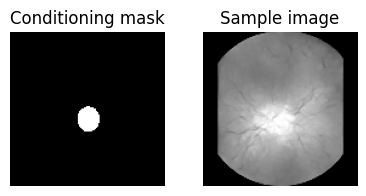

epoch:5/150: training loss 0.006701
validation loss: 0.0052
Best ControlNet saved at epoch 10 with val loss 0.0052
Checkpoint saved: checkpoint_epoch_10_fundus.pth


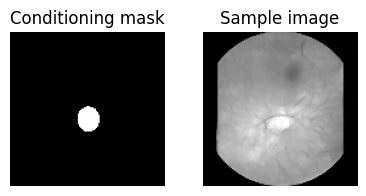

epoch:10/150: training loss 0.005698
validation loss: 0.0073
Checkpoint saved: checkpoint_epoch_15_fundus.pth


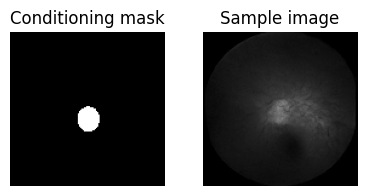

epoch:15/150: training loss 0.005320
validation loss: 0.0049
Best ControlNet saved at epoch 20 with val loss 0.0049
Checkpoint saved: checkpoint_epoch_20_fundus.pth


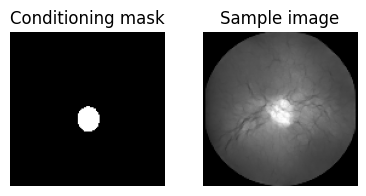

epoch:20/150: training loss 0.005485
validation loss: 0.0070
Checkpoint saved: checkpoint_epoch_25_fundus.pth


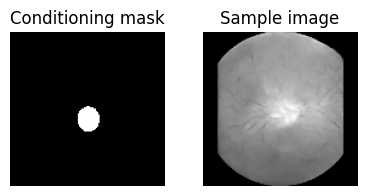

epoch:25/150: training loss 0.005498
validation loss: 0.0046
Best ControlNet saved at epoch 30 with val loss 0.0046
Checkpoint saved: checkpoint_epoch_30_fundus.pth


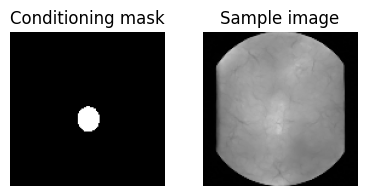

epoch:30/150: training loss 0.005296
validation loss: 0.0071
Checkpoint saved: checkpoint_epoch_35_fundus.pth


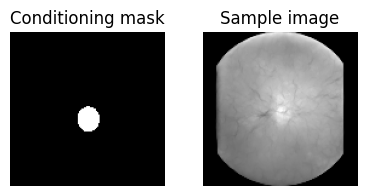

epoch:35/150: training loss 0.004936
validation loss: 0.0037
Best ControlNet saved at epoch 40 with val loss 0.0037
Checkpoint saved: checkpoint_epoch_40_fundus.pth


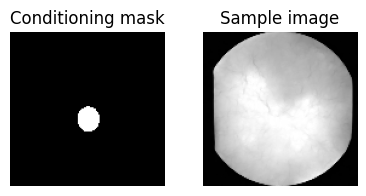

epoch:40/150: training loss 0.005557
validation loss: 0.0044
Checkpoint saved: checkpoint_epoch_45_fundus.pth


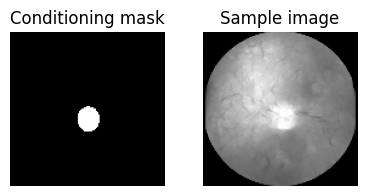

epoch:45/150: training loss 0.004509
validation loss: 0.0046
Checkpoint saved: checkpoint_epoch_50_fundus.pth


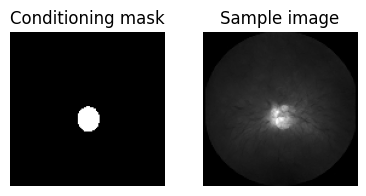

epoch:50/150: training loss 0.005323
validation loss: 0.0060
Checkpoint saved: checkpoint_epoch_55_fundus.pth


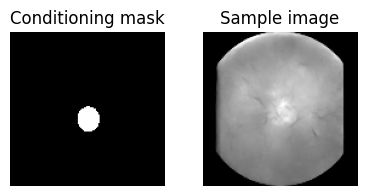

epoch:55/150: training loss 0.005747
validation loss: 0.0044
Checkpoint saved: checkpoint_epoch_60_fundus.pth


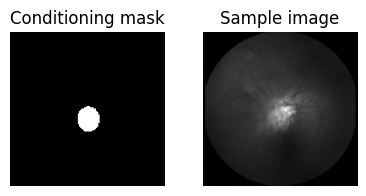

epoch:60/150: training loss 0.005037
validation loss: 0.0040
Checkpoint saved: checkpoint_epoch_65_fundus.pth


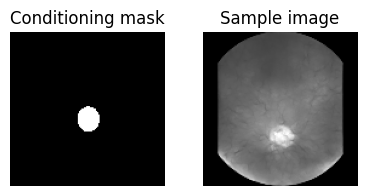

epoch:65/150: training loss 0.006277
validation loss: 0.0050
Checkpoint saved: checkpoint_epoch_70_fundus.pth


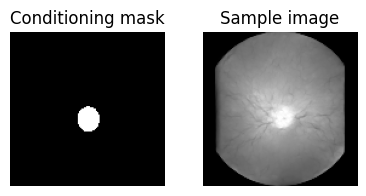

epoch:70/150: training loss 0.005132
validation loss: 0.0052
Checkpoint saved: checkpoint_epoch_75_fundus.pth


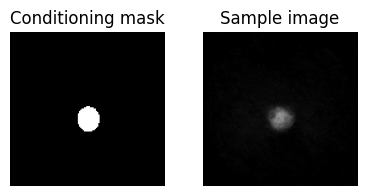

epoch:75/150: training loss 0.005242
validation loss: 0.0047
Checkpoint saved: checkpoint_epoch_80_fundus.pth


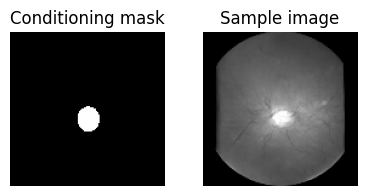

epoch:80/150: training loss 0.005224
validation loss: 0.0050
Checkpoint saved: checkpoint_epoch_85_fundus.pth


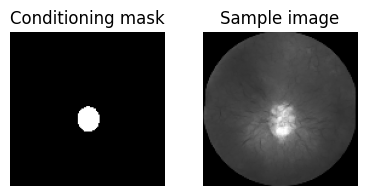

epoch:85/150: training loss 0.004942
validation loss: 0.0060
Checkpoint saved: checkpoint_epoch_90_fundus.pth


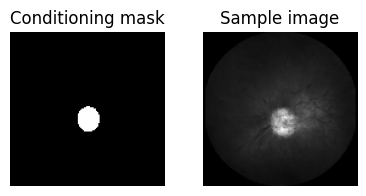

epoch:90/150: training loss 0.005616
validation loss: 0.0052
Checkpoint saved: checkpoint_epoch_95_fundus.pth


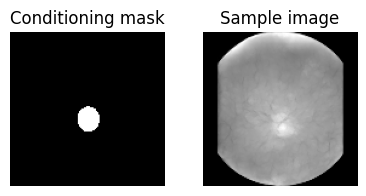

epoch:95/150: training loss 0.004866
validation loss: 0.0051
Checkpoint saved: checkpoint_epoch_100_fundus.pth


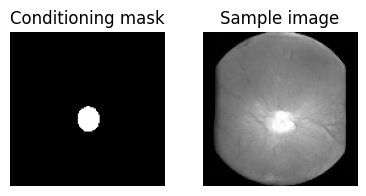

epoch:100/150: training loss 0.004897
validation loss: 0.0076
Checkpoint saved: checkpoint_epoch_105_fundus.pth


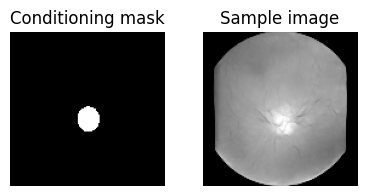

epoch:105/150: training loss 0.005666
validation loss: 0.0060
Checkpoint saved: checkpoint_epoch_110_fundus.pth


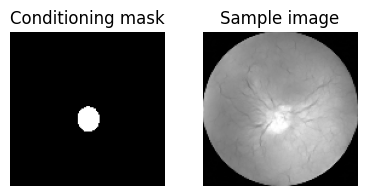

epoch:110/150: training loss 0.005041
validation loss: 0.0059
Checkpoint saved: checkpoint_epoch_115_fundus.pth


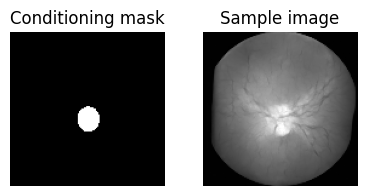

epoch:115/150: training loss 0.005228
validation loss: 0.0049
Checkpoint saved: checkpoint_epoch_120_fundus.pth


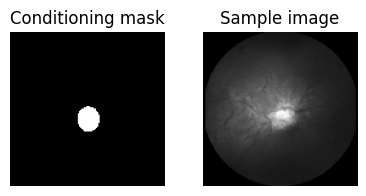

epoch:120/150: training loss 0.004779
validation loss: 0.0047
Checkpoint saved: checkpoint_epoch_125_fundus.pth


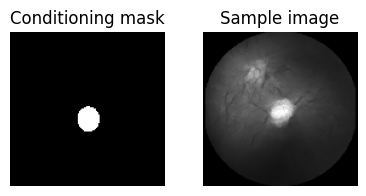

epoch:125/150: training loss 0.005023
validation loss: 0.0051
Checkpoint saved: checkpoint_epoch_130_fundus.pth


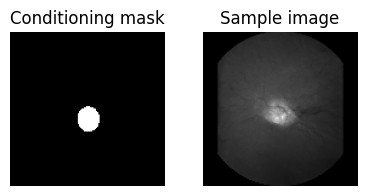

epoch:130/150: training loss 0.005158
validation loss: 0.0055
Checkpoint saved: checkpoint_epoch_135_fundus.pth


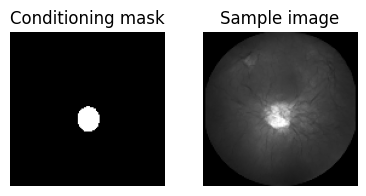

epoch:135/150: training loss 0.005605
validation loss: 0.0046
Checkpoint saved: checkpoint_epoch_140_fundus.pth


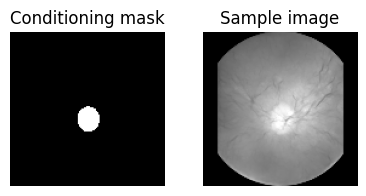

epoch:140/150: training loss 0.006094
validation loss: 0.0039
Checkpoint saved: checkpoint_epoch_145_fundus.pth


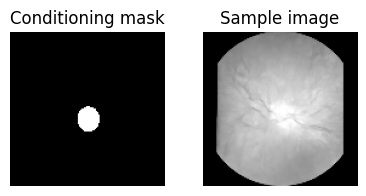

epoch:145/150: training loss 0.004894
validation loss: 0.0041
Checkpoint saved: checkpoint_epoch_150_fundus.pth


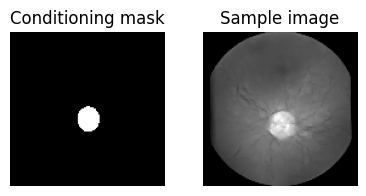

train completed, total time: 10102.109642505646.


In [13]:
max_epochs = 150
val_interval = 5
print_every = 5
epoch_loss_list = []
val_epoch_loss_list = []


def random_resize_masks(masks, min_ratio=0.6, max_ratio=1.4, target_size=128):
    resized_masks = []
    for mask in masks:
        b, h, w = mask.shape[-3:]
        ratio = torch.empty(1).uniform_(min_ratio, max_ratio).item()
        new_size = int(h * ratio)

        # Resize mask
        resized = F.interpolate(mask.unsqueeze(0), size=(new_size, new_size), mode="nearest").squeeze(0)

        # Center-pad or crop to target size
        canvas = torch.zeros_like(mask)
        offset = (target_size - new_size) // 2

        if new_size <= target_size:
            canvas[:, offset:offset+new_size, offset:offset+new_size] = resized
        else:
            canvas = resized[:, -offset:target_size-offset, -offset:target_size-offset]

        resized_masks.append(canvas)
    return torch.stack(resized_masks)


#highlight ControlNet checkpointing
best_val_loss = float("inf")
controlnet_ckpt_dir = Path.cwd() / "Checkpoints" / controlnet_model_name
controlnet_ckpt_dir.mkdir(parents=True, exist_ok=True)

model_ckpt_path = Path.cwd() / "Checkpoints" / model_name / f"best_model_{dataset_used}.pth"
model.load_state_dict(torch.load(model_ckpt_path, map_location=device))

scaler = GradScaler("cuda")
total_start = time.time()
for epoch in range(max_epochs):
    controlnet.train()
    epoch_loss = 0
    for batch in train_loader:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)
        cond_masks = random_resize_masks(masks)

        # idx = 0  # Index in batch to visualize
        # fig, axes = plt.subplots(1, 2, figsize=(4, 2))
        # axes[0].imshow(masks[idx, 0].cpu(), cmap="gray", vmin=0, vmax=1)
        # axes[0].set_title("Original Mask")
        # axes[0].axis("off")
        #
        # axes[1].imshow(cond_masks[idx, 0].cpu(), cmap="gray", vmin=0, vmax=1)
        # axes[1].set_title("Resized Mask")
        # axes[1].axis("off")
        #
        # plt.tight_layout()
        # plt.show()

        optimizer.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            noise_pred = controlnet_inferer(
                inputs=images,
                diffusion_model=model,
                controlnet=controlnet,
                noise=noise,
                timesteps=timesteps,
                cn_cond=cond_masks,
            )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    if epoch % print_every == 0:
        msg = f"epoch:{epoch:d}/{max_epochs:d}: training loss {np.mean(epoch_loss / len(train_loader)):4f}"
        print(msg)

    epoch_loss_list.append(epoch_loss / len(train_loader))

    if (epoch + 1) % val_interval == 0:
        controlnet.eval()
        val_epoch_loss = 0
        for batch in val_loader:
            images = batch["image"].to(device)
            masks = batch["mask"].to(device)
            cond_masks = random_resize_masks(masks)

            with torch.no_grad():
                with autocast("cuda", enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, controlnet_inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()

                    noise_pred = controlnet_inferer(
                        inputs=images,
                        diffusion_model=model,
                        controlnet=controlnet,
                        noise=noise,
                        timesteps=timesteps,
                        cn_cond=cond_masks,
                    )
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())
            val_epoch_loss += val_loss.item()

        avg_val_loss = val_epoch_loss / len(val_loader)
        val_epoch_loss_list.append(avg_val_loss)
        print(f"validation loss: {avg_val_loss:.4f}")

        # Save best ControlNet model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_path = controlnet_ckpt_dir / f"best_model_{dataset_used}.pth"
            torch.save(controlnet.state_dict(), best_path)
            print(f"Best ControlNet saved at epoch {epoch+1} with val loss {best_val_loss:.4f}")

        # Save periodic ControlNet checkpoint
        checkpoint_path = controlnet_ckpt_dir / f"checkpoint_epoch_{epoch+1}_{dataset_used}.pth"
        torch.save(controlnet.state_dict(), checkpoint_path)
        print(f"Checkpoint saved: {checkpoint_path.name}")


        # Sampling image during training with controlnet conditioning

        with torch.no_grad():
            with autocast("cuda", enabled=True):
                noise = torch.randn((1, 1, 128, 128)).to(device)
                rand_cond_mask = random_resize_masks(masks[0, None, ...])
                sample = controlnet_inferer.sample(
                    input_noise=noise,
                    diffusion_model=model,
                    controlnet=controlnet,
                    cn_cond=rand_cond_mask,
                    scheduler=scheduler,
                    verbose=False,
                )
        plt.subplots(1, 2, figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(masks[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Conditioning mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sample[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Sample image")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

## Sample with ControlNet conditioning
First we'll provide a few different masks from the validation data as conditioning. The samples should respect the shape of the conditioning mask, but don't need to have the same content as the corresponding validation image.

Model loaded from C:\Users\Marquis\Desktop\dmcaf\DMCAF\medical_image\Checkpoints\DiffusionModelUNet\best_model_fundus.pth


sampling...: 100%|████████████████████████████████████████████████████████| 1000/1000 [01:30<00:00, 11.09it/s]


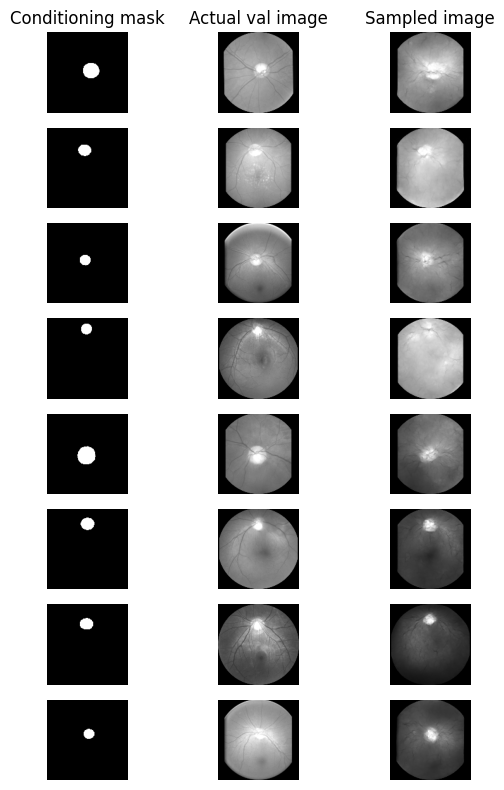

In [17]:
#highlight Model and ControlNet checkpoint loading

model_ckpt_path = Path.cwd() / "Checkpoints" / model_name / f"best_model_{dataset_used}.pth"
controlnet_ckpt_path = Path.cwd() / "Checkpoints" / controlnet_model_name / f"best_model_{dataset_used}.pth"

model.load_state_dict(torch.load(model_ckpt_path, map_location=device))
controlnet.load_state_dict(torch.load(controlnet_ckpt_path, map_location=device))
print(f"Model loaded from {model_ckpt_path}")

model.eval()
controlnet.eval()


progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110, position=0, leave=True)
progress_bar_sampling.set_description("sampling...")
num_samples = 8
sample = torch.randn((num_samples, 1, 128, 128)).to(device)

val_batch = first(val_loader)
val_images = val_batch["image"].to(device)
val_masks = val_batch["mask"].to(device)
for t in progress_bar_sampling:
    with torch.no_grad():
        with autocast("cuda", enabled=True):
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=sample,
                timesteps=torch.Tensor((t,)).to(device).long(),
                controlnet_cond=val_masks[:num_samples, ...]
            )
            noise_pred = model(
                sample,
                timesteps=torch.Tensor((t,)).to(device),
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

plt.subplots(num_samples, 3, figsize=(6, 8))
for k in range(num_samples):
    plt.subplot(num_samples, 3, k * 3 + 1)
    plt.imshow(val_masks[k, 0, ...].cpu().numpy(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Conditioning mask")
    plt.subplot(num_samples, 3, k * 3 + 2)
    plt.imshow(val_images[k, 0, ...].cpu().numpy(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Actual val image")
    plt.subplot(num_samples, 3, k * 3 + 3)
    plt.imshow(sample[k, 0, ...].cpu().numpy(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Sampled image")
plt.tight_layout()
plt.show()

In [12]:
#What happens if we invent some masks? Let's try a circle, and a square
# xx, yy = np.mgrid[:64, :64]
# circle = ((xx - 32) ** 2 + (yy - 32) ** 2) < 30**2
#
# square = np.zeros((64, 64))
# square[10:50, 10:50] = 1
#
# mask = np.concatenate((circle[None, None, ...], square[None, None, ...]), axis=0)
# mask = torch.from_numpy(mask.astype(np.float32)).to(device)
#
#
# progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110, position=0, leave=True)
# progress_bar_sampling.set_description("sampling...")
# num_samples = 2
# sample = torch.randn((num_samples, 1, 64, 64)).to(device)
#
# for t in progress_bar_sampling:
#     with torch.no_grad():
#         with autocast("cuda", enabled=True):
#             down_block_res_samples, mid_block_res_sample = controlnet(
#                 x=sample, timesteps=torch.Tensor((t,)).to(device).long(), controlnet_cond=mask
#             )
#             noise_pred = model(
#                 sample,
#                 timesteps=torch.Tensor((t,)).to(device),
#                 down_block_additional_residuals=down_block_res_samples,
#                 mid_block_additional_residual=mid_block_res_sample,
#             )
#             sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)
#
# plt.subplots(num_samples, 2, figsize=(4, 4))
# for k in range(num_samples):
#     plt.subplot(num_samples, 2, k * 2 + 1)
#     plt.imshow(mask[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
#     plt.axis("off")
#     if k == 0:
#         plt.title("Conditioning mask")
#     plt.subplot(num_samples, 2, k * 2 + 2)
#     plt.imshow(sample[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
#     plt.axis("off")
#     if k == 0:
#         plt.title("Sampled image")
# plt.tight_layout()
# plt.show()

In [ ]:
#highlight Brain Imaging experiment loop

# Base output directory
current_dir = Path.cwd()
output_base_dir = current_dir / "Outputs"

# Create base if not exists
output_base_dir.mkdir(parents=True, exist_ok=True)

# Find next available experiment folder
existing = [d for d in output_base_dir.iterdir() if d.is_dir() and d.name.startswith("experiment")]
exp_nums = [int(d.name.replace("experiment", "")) for d in existing if d.name.replace("experiment", "").isdigit()]
next_exp_num = max(exp_nums) + 1 if exp_nums else 0

# Create new experiment directory
output_dir = output_base_dir / f"experiment{next_exp_num}"
masks_dir = output_dir / "Masks"
images_dir = output_dir / "Images"

masks_dir.mkdir(parents=True, exist_ok=True)
images_dir.mkdir(parents=True, exist_ok=True)

print(f"Created experiment directory: {output_dir}")

# Load best checkpoints
best_model_ckpt_path = current_dir / "Checkpoints/DiffusionModelUNet/best_model.pth"
best_controlnet_ckpt_path = current_dir / "Checkpoints/ControlNet_DiffusionModelUNet/best_model.pth"
model_ckpt = torch.load(best_model_ckpt_path, map_location=device)
controlnet_ckpt = torch.load(best_controlnet_ckpt_path, map_location=device)

model.load_state_dict(model_ckpt)
controlnet.load_state_dict(controlnet_ckpt)

model.eval()
controlnet.eval()

# Load val data
for batch_idx, val_batch in enumerate(val_loader):
    val_images = val_batch["image"].to(device)
    val_masks = val_batch["mask"].to(device)

    num_samples = val_images.shape[0]
    sample = torch.randn((num_samples, 1, 64, 64)).to(device)

    for t in tqdm(scheduler.timesteps, desc=f"Sampling batch {batch_idx}", leave=False):
        with torch.no_grad():
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=sample, timesteps=torch.tensor([t]*num_samples).to(device).long(), controlnet_cond=val_masks
            )
            noise_pred = model(
                sample,
                timesteps=torch.tensor([t]*num_samples).to(device),
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

    for i in range(num_samples):
        mask_img = val_masks[i, 0].cpu().numpy()
        result_img = sample[i, 0].cpu().numpy()

        plt.imsave(masks_dir / f"mask_{i}.png", mask_img, cmap="gray", vmin=0, vmax=1)
        plt.imsave(images_dir / f"generated_{i}.png", result_img, cmap="gray", vmin=0, vmax=1)


In [9]:
import cv2
from torch import nn
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths
input_dir = Path("Outputs") / "experiment4" / "Images"
output_base = Path("Outputs") / "predictions2"
images_out = output_base / "Images"
masks_out = output_base / "Masks"

# Create output folders
images_out.mkdir(parents=True, exist_ok=True)
masks_out.mkdir(parents=True, exist_ok=True)

# Load model and processor
processor = AutoImageProcessor.from_pretrained("pamixsun/segformer_for_optic_disc_cup_segmentation")
model = SegformerForSemanticSegmentation.from_pretrained("pamixsun/segformer_for_optic_disc_cup_segmentation")
model.to(device)
model.eval()

# Process each image
image_paths = sorted(input_dir.glob("*.png"))

for img_path in tqdm(image_paths, desc="Processing images"):
    # Load image
    image_bgr = cv2.imread(str(img_path))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Prepare input
    inputs = processor(image_rgb, return_tensors="pt").to(device)

    # Predict on GPU
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits  # stays on GPU

    # Resize prediction to original size (on GPU)
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image_rgb.shape[:2],
        mode="bilinear",
        align_corners=False,
    )

    # Move to CPU for saving
    pred_mask = upsampled_logits.argmax(dim=1)[0].cpu().numpy().astype(np.uint8)

    # Save input image and prediction mask
    filename = img_path.name
    cv2.imwrite(str(images_out / filename), image_bgr)
    plt.imsave(masks_out / filename, pred_mask, cmap="gray", vmin=0, vmax=2)

print("All predictions saved.")

Using device: cuda


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Processing images: 100%|██████████| 512/512 [00:22<00:00, 22.46it/s]

All predictions saved.
